**Project 1**

TODO

*   better error handling 
> * when a max connection exception is thrown
> * for some url combinations


* threads? although too hard and not necessary



Web Crawler Libraries:

HTML parser - BeautifulSoup

HTTP requests - Python requests lib

In [0]:
try: 
    from BeautifulSoup import BeautifulSoup # html parser
except ImportError:
    from bs4 import BeautifulSoup
import requests #http request handling library
import pandas as pd #data structure for intermediate storage of links and output of CSV
import re 
import os 
import matplotlib.pyplot as plt #plot Zipf's law graphs
import math
from tqdm import tqdm #progress bar creation
import urllib
import urllib.robotparser as urobot #robot.text
from urllib.parse import urlparse
from urllib.parse import urlunparse
from tabulate import tabulate



# **Utility Functions**

HTTP request functions

In [0]:
def get_html(url):
  try:
    r = requests.get(url) #add verify=False to handle the SSL Error
    #print(r.headers['content-type'])
    if r.status_code == requests.codes.ok and 'text/html' in r.headers['content-type']:
      return r.text
    else:
      return False
  
  except Exception as e:
    #print('\n'+e+'\n')
    return False

  
#test
# res = get_html('https://www.cpp.edu/~dmhughes/')
# print(type(res))
# print(res)
#res = get_html('https://avatars2.githubusercontent.com/u/6970911?s=400&v=4')
#print(type(res))
#print(res)


In [0]:
#https://stackoverflow.com/questions/49581758/checking-if-robots-txt-file-exists-in-python3
def does_url_exist(url):
    try: 
        r = requests.head(url)
        if r.status_code == requests.codes.ok:
            return True
        else:
            return False
    except requests.exceptions.RequestException as e:
        print(e)
        # handle your exception
        
#does_url_exist('https://www.cpp.edu/~dmhughes/')

In [0]:
# def check_content_type(url, content_type="text/html"):
#   try: 
#     r = requests.head(url)
#     if r.status_code < 400 and content_type in r.headers['content-type']:
#         return True
#     else:
#         return False
#   except requests.exceptions.RequestException as e:
#     print(e)
#     # handle your exception

In [0]:
def check_robots(url):
  
  #create a directory for saved html
  if not os.path.exists('robots'):
      os.makedirs('robots')
  
  x = urlparse(url)
  robots_url = urlunparse((x.scheme, x.netloc, 'robots.txt', None, None,None))
  robots_filename = x.netloc + "_" + 'robots.txt'
  #print(robots_url)
  
  #checks if robots.txt already downloaded
  if(os.path.isfile('robots/' + robots_filename)):
    file = open('robots/' + robots_filename)
    rp = urobot.RobotFileParser()
    txt = file.read()
    rp.parse(txt)
    file.close()
    if rp.can_fetch("*", url):
      return True
    else:
      print("DENIED: " + url)
      return False
    
  #downloads and stores robots.txt file  
  elif does_url_exist(robots_url):
    rp = urobot.RobotFileParser()
    try:
      txt = urllib.request.urlopen(robots_url).read()
    except Exception as e:
      #print('\n'+e+'\n')
      return False
    rp.parse(txt.decode("utf-8").splitlines())
    
    with open('robots/' + robots_filename, "w") as text_file:
        text_file.write(txt.decode("utf-8"))
        
    if rp.can_fetch("*", url):
      return True
    else:
      print("DENIED: " + url)
      return False
    
  #otherwise return true if no robot.txt file
  else:
    return True
  
  
  
# x = urlparse("https://docs.python.org/3/library/urllib.parse.html#module-urllib.parse")
# robots_url = urlunparse((x.scheme, x.netloc, 'robots.txt', None, None,None))
# print(robots_url)

HTML parsing functions

In [0]:
def parse_html(html_doc,url) :
  #first create a BeautifulSoup object
  soup = BeautifulSoup(html_doc, 'html.parser')
  links = []
  num_outlinks=0
  word_dict={} #create a {word: count} dict
  
  word_dict=parse_text(soup)

  #parse all links
  for link in soup.find_all('a',href=True):
    href=link.get('href').rstrip('/') #get the href and remove slash (/) if '/'is at the end of the link
    if (href !='/') and (href) and ('@' not in href):
      if ('http:'not in href) and ('https:' not in href):
        if '//' in href:        #handle the link that starts with '//'
          links.append('http:'+href)
          links.append('https:'+href)
        elif not has_TLD(url,href): # check if the url and href has the same top level domain(TLD)
          url=url.rstrip('/')
          href=href.lstrip('/')
          links.append(url+'/'+href) #add the current url
      else:
        links.append(href)
      num_outlinks+=1  
  #num_outlinks= len(links)         #should the number of outlinks in the csv be unqiue links or not? I think it should be unique
    
  #urls to add to queue, list of urls, num_outlinks, word dictionary/count
  return word_dict, links, num_outlinks


# #test
# res = parse_html(html_doc_alice)
# print(res[0])
# print(res[1])
# print(res[2])

Parse text


In [0]:
def parse_text(soup):
  #Extract script and style elements from the HTML document
  for script in soup(['script','style','video']): 
    script.extract() 
    
  r=re.compile(r'[A-Za-z]+[\-\']?[A-Za-z]+|[A-Zaz]+') #remove escape sequences and numbers from text
  text_str_list = r.findall(soup.get_text().lower()) #get a list that contains all accepted tokens. 
  word_dict = {} #create a {word: count} dict
  for word in text_str_list:
      if word in word_dict:
        word_dict[word] += 1
      else:
        word_dict[word] = 1
      
  return word_dict  


Check for Top level Domain

In [0]:
def has_TLD(url,href):
  TLD_list=['.html','.com','.edu','.org','.gov']
  
  for TLD in TLD_list:
    if TLD in url and TLD in href:
      return True;
  return False    
    

Reprocess files

In [0]:
def reprocess_index(repository_dir):
  re_word_index = {}
  for root, dirs, files in os.walk(repository_dir):
      for file_path in tqdm(files):
          if file_path.endswith('.html'):
            file = open(root+'/' +file_path, "r")
            html_doc = file.read()
            result = parse_html(html_doc, "")
            re_word_index = {**result[0],**re_word_index}
            file.close()
         
  return re_word_index
  
  
# word_index = reprocess_index('repository') 
# print(word_index)

Merge two dictionaries

In [0]:
def merge_two_dicts(LHS, RHS):
  for word in RHS:
    if word in LHS:
      LHS[word]+=RHS[word] #add values
    else:
      LHS[word]=RHS[word]    # modifies result with RHS's keys and values & returns None
  return LHS

**Testing Code/Functions**

In [0]:
# #parsing test code

# def print_parse_html(html_doc) :
#   #first create a BeautifulSoup object
#   soup = BeautifulSoup(html_doc, 'html.parser')
  
#   #parse text
#   print(type(soup.get_text()))
#   print(soup.get_text())
  
  
#   #parse all links
#   for link in soup.find_all('a'):
#     print(link.get('href'))

    
    
# html_doc_alice = """
# <html><head><title>The Dormouse's story</title></head>
# <body>
# <p class="title"><b>The Dormouse's story</b></p>

# <p class="story">Once upon a time there were three little sisters; and their names were
# <a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
# <a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
# <a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
# and they lived at the bottom of a well.</p>

# <button onclick="playPause()">Play/Pause</button>
# <video width="320" height="240" controls>
#   <source src="movie.mp4" type="video/mp4">
#   <source src="movie.ogg" type="video/ogg">
#   Your browser does not support the video tag.
# </video>
# <img src="smiley.gif" alt="Smiley face" height="42" width="42">

# <p class="story">...</p>
# """

# print_parse_html(html_doc_alice)

In [0]:
# #pandas testing
# df = pd.DataFrame(columns=['Url','OutLinks'])
# df.loc[df.shape[0]] = ['www.1.com',3]
# df.head()
# df.loc[df.shape[0]] = ['www.2.com',3]
# df.head()
# df.loc[df.shape[0]] = ['www.3.com',3]
# df.head()

# df.to_csv("links.csv")

# **Main Driver**

In [15]:
#constants
MAX_PAGES = 200
SEED = 'https://www.cnn.com'

#create a directory for saved html
if not os.path.exists('repository'):
    os.makedirs('repository')

    
queue = [SEED]
word_index = {}
i_pages = 0
links_df = pd.DataFrame(columns=['URL','number_of_outlinks']) #serves as a history of visited links and creation of url/outlinks csv file

with tqdm(total=MAX_PAGES) as pbar:
  while len(queue) != 0 and i_pages < MAX_PAGES:
    url = queue.pop(0)
    html = get_html(url)
    #print('url: ',url)
    if html != False:
      result = parse_html(html,url) #returns (word_dict, links, num_outlinks)     
      i_pages += 1
      pbar.update(1)
      links_df.loc[links_df.shape[0]+1] = [url, result[2]]

      #save textfile
      with open("repository/File" + str(i_pages) + ".html", "w") as text_file:
        text_file.write("<!--" + url + "-->")
        text_file.write(html)

      word_index =  merge_two_dicts(word_index,result[0]) # merge index

      #check if the outlink has already been explored, if not add to queue and dataframe.
      for link in result[1]:
        if link not in links_df['URL'] and link not in queue and check_robots(url): 
          queue.append(link) # do we want to append links that are already added in the queue?         
          #print (link)
    #print(queue)
  
links_df.to_csv("report.csv")    
  

100%|██████████| 200/200 [08:58<00:00,  2.19s/it]


# **Print Zipf's Law Graphs**

number of words: 19498
[('the', 6520), ('to', 4510), ('of', 3668), ('and', 3472), ('a', 3038), ('in', 2458), ('for', 2039), ('on', 1702), ('is', 1602), ('you', 1572), ('your', 1357), ('cnn', 1331), ('with', 1085), ('or', 1085), ('that', 970), ('news', 945), ('this', 885), ('are', 867), ('at', 862), ('from', 826), ('all', 761), ('by', 726), ('it', 682), ('be', 629), ('more', 617), ('as', 573), ('will', 561), ('not', 537), ('have', 523), ('credit', 506), ('about', 483), ('an', 476), ('our', 475), ('new', 473), ('we', 464), ('after', 462), ('can', 416), ('any', 396), ('up', 394), ('best', 370), ('us', 368), ('card', 365), ('edition', 359), ('was', 355), ('use', 349), ('account', 348), ('how', 347), ('he', 339), ('back', 334), ('has', 330), ('out', 328), ('no', 325), ('network', 322), ('rights', 315), ('pm', 312), ('world', 310), ('cash', 307), ('his', 306), ('may', 305), ('now', 302), ('inc', 300), ('apr', 299), ('its', 293), ('one', 292), ('if', 292), ('but', 289), ('com', 285), ('first'

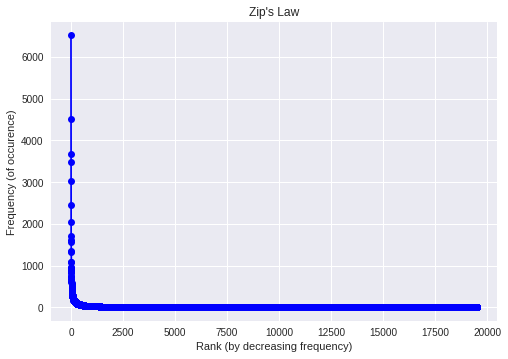

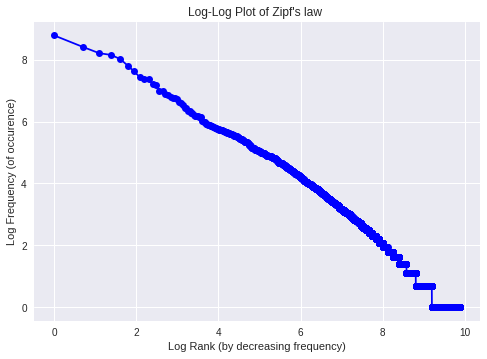

In [16]:
sorted_index = sorted(word_index.items(), key=lambda kv: kv[1], reverse=True) #create a list that is the word_dict index sorted by value
print('number of words:', len (sorted_index))
print(sorted_index)


#print plot
freqs = [i[1] for i in sorted_index]       #get the frequency of each word
#N_total_words = sum(freqs)                 #get total number of words found
#P_probs = [i/N_total_words for i in freqs]  #calc P = f/n
axis = range(1,len(freqs)+1)

plt.plot(axis, freqs, '-bo')
plt.title("Zip\'s Law")
plt.ylabel('Frequency (of occurence)')
plt.xlabel('Rank (by decreasing frequency)')
plt.savefig('zipfs.png')
plt.show()


#print log-log plot (for the linear line effect)
log_freqs = [math.log(i) for i in freqs]
log_axis = [math.log(i) for i in axis]

plt.plot(log_axis, log_freqs, '-bo')
plt.title('Log-Log Plot of Zipf\'s law ')
plt.ylabel('Log Frequency (of occurence)')
plt.xlabel('Log Rank (by decreasing frequency)')
plt.savefig('loglogzipfs.png')
plt.show()


Print table

In [17]:
num_rows=25
print ("{:<5} {:<15} {:<10} {:<5} {:<15} {:<10} {:<5} {:<15} {:<11} {:<5} {:<15} {:<7}".format
                                                ('Rank','Word','Freq','Rank','Word','Freq','Rank','Word','Freq','Rank','Word','Freq'))
print('-'*130)
for i in range(num_rows):
  print ("{:<5} {:<15} {:<7}{:<3} {:<5} {:<15} {:<7}{:<3} {:<5} {:<15} {:<7} {:<3} {:<5} {:<15} {:<7}".format((i+1),sorted_index[i][0],sorted_index[i][1],'|',
                                                                                  (i+num_rows+1),sorted_index[i+num_rows][0],sorted_index[i+num_rows][1],'|',
                                                                                  (i+num_rows*2+1),sorted_index[i+num_rows*2][0],sorted_index[i+num_rows*2][1],'|',
                                                                                  (i+num_rows*3+1),sorted_index[i+num_rows*3][0],sorted_index[i+num_rows*3][1]))
  
  

Rank  Word            Freq       Rank  Word            Freq       Rank  Word            Freq        Rank  Word            Freq   
----------------------------------------------------------------------------------------------------------------------------------
1     the             6520   |   26    as              573    |   51    out             328     |   76    bleacher        268    
2     to              4510   |   27    will            561    |   52    no              325     |   77    their           264    
3     of              3668   |   28    not             537    |   53    network         322     |   78    other           258    
4     and             3472   |   29    have            523    |   54    rights          315     |   79    like            257    
5     a               3038   |   30    credit          506    |   55    pm              312     |   80    reserved        253    
6     in              2458   |   31    about           483    |   56    world           3